# MPC

In [ ]:
pip install cvxpy

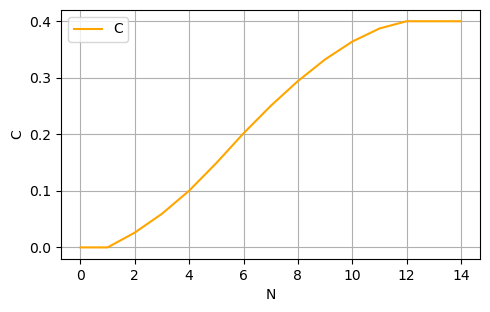

In [48]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Continuous-time system matrices
A_continuous = np.array([[1, 0.2], [-0.010416, 1]])
B_continuous = np.array([[0.2, 0.2], [-0.32, -0.16]])

# Discretization using the Euler method
dt = 0.1  # time step
A_discrete = np.eye(2) + dt * A_continuous
B_discrete = dt * B_continuous

# Cost matrices
Q = np.array([[25, 0], [0, 0.1]])
R = np.array([[1, 0], [0, 1]])

# Horizon and initial state
N = 14  # Horizon
x0 = np.array([0, 0])  # Initial state

# Define optimization variables
X = cp.Variable((2, N + 1))
U = cp.Variable((2, N))

# State variable constraints
H_min = 0.5
H_max = 2
C_min = 0.0
C_max = 0.4

state_constraints = [
    H_min <= X[0, 1:N + 1], X[0, 1:N + 1] <= H_max,
    C_min <= X[1, 1:N + 1], X[1, 1:N + 1] <= C_max
]

# Define cost function
cost = 0
for k in range(N):
    cost += cp.quad_form(X[:, k + 1], Q) + cp.quad_form(U[:, k], R)

# Define MPC constraints
constraints = [X[:, 0] == x0]
for k in range(N):
    constraints += [X[:, k + 1] == A_discrete @ X[:, k] + B_discrete @ U[:, k]]
constraints += state_constraints

# Define and solve the optimization problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()

# Extract the optimal state and input trajectory
X_opt = X.value
U_opt = U.value

# Plot results
time_points = np.arange(N + 1)

# Plot for Optimal H
plt.figure(figsize=(5, 12))
#plt.subplot(4, 1, 1)
#plt.plot(time_points, X_opt[0, :].flatten(), label='Optimal H', color='blue')
#plt.xlabel('Time Step')
#plt.legend()
#plt.grid(True)

# Plot for Optimal C
plt.subplot(4, 1, 2)
plt.plot(time_points, X_opt[1, :].flatten(), label='C', color='orange')
plt.ylabel('C')
plt.xlabel('N')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

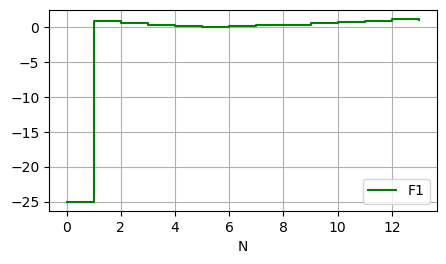

In [49]:
# Plot for Optimal Control Inputs
plt.figure(figsize=(5, 12))
plt.subplot(4, 1, 3)
plt.step(time_points[:-1], U_opt[0, :].flatten(), label='F1', color='green', where='post')
plt.xlabel('N')
plt.legend()
plt.grid(True)




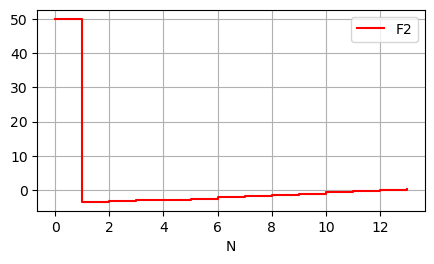

In [50]:
# Plot for Optimal Control Inputs
plt.figure(figsize=(5, 12))
plt.subplot(4, 1, 4)
plt.step(time_points[:-1], U_opt[1, :].flatten(), label='F2', color='red', where='post')
plt.xlabel('N')
plt.legend()
plt.grid(True)

# Non-linear MPC 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# System parameters

# Initial state
H_init = 1.38
C_init = 0.35

# MPC parameters
N = 20  # Horizon length
dt = 0.1  # Time step

# Weighting matrices
Q = np.diag([0.22, 1.0])
R = np.diag([1.0, 1.0])

# Initial state
x_init = np.array([H_init, C_init])

# Cost function
def mpc_cost(U, x0, Q, R, N):
    J = 0.5 * np.dot((x0 - np.array([1.44, 0.4])).T, np.dot(Q, (x0 - np.array([1.4, 0.4]))))
   
    for k in range(N):
        u_k = U[2 * k:2 * k + 2]
        x_k1 = ode(x0, u_k, dt)
        J += 0.5 * np.dot(u_k.T, np.dot(R, u_k))
        J += 0.5 * np.dot((x_k1 - np.array([1.44, 0.4])).T, np.dot(Q, (x_k1 - np.array([1.44, 0.4]))))
        x0 = x_k1

    return J

# System dynamics
def ode(x, u, dt):
    H, C = x
    F1, F2 = u

    eq1 = 1 / 0.05 * (F1 + F2 - 0.125 * np.sqrt(H))
    eq2 = 1 / (0.5 * H) * (F1 * (0.2 - C) + F2 * (0.5 - C))


    x_next = np.array([H + eq1 * dt, C + eq2 * dt])
    return x_next

# MPC optimization
def mpc_optimization(Q, R, x0, N, umin, umax):
    u_init = np.zeros(2 * N)  # Initial guess for input trajectory
    u_bounds = [(umin[0], umax[0])] * N + [(umin[1], umax[1])] * N  # Bounds on the input trajectory
    


    # Call scipy.optimize.minimize to solve the MPC optimization problem
    sol = minimize(mpc_cost, u_init, args=(x0, Q, R, N), method='SLSQP', bounds=u_bounds, options={'eps': 1e-6, 'disp': True})

    # The optimized input trajectory is stored in sol.x
    U = sol.x
    # Only the first input values are implemented according to receding horizon implementation
    u_optimal = U[:2]
    return u_optimal

# Closed-loop simulation & predictions
x0 = np.array([H_init, C_init])
u1 = np.zeros((N, 2))
x_history = np.zeros((N + 1, 2))
U_history = np.zeros((N, 2))

for k in range(N):
    # Only the first u is actually implemented
    x_k = x0
    uk1 = mpc_optimization(Q, R, x_k, N, [0, 0], [1, 1])  # Calls MPC function to calculate the optimal uk
    u1[k, :] = uk1
    U_history[k, :] = uk1
    # Use Euler's method to integrate the nonlinear system for one sampling time
    x_k1 = ode(x_k, uk1, dt)
    x0 = x_k1
    x_history[k + 1, :] = x_k1

# Plotting
tk = np.arange(0, (N + 1) * dt, dt)  # Adjust the length of tk
plt.figure(figsize=(8, 6))
plt.plot(tk, x_history[:, 0], label='H')
plt.plot(tk, x_history[:, 1], label='C')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.title('Evolution of State Variables H and C over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.step(tk[:-1], U_history[:, 0], label='F1', where='post')  # Adjust the length of tk in plt.step
plt.step(tk[:-1], U_history[:, 1], label='F2', where='post')  # Adjust the length of tk in plt.step
plt.xlabel('Time')
plt.ylabel('Control Inputs')
plt.title('Optimal Control Inputs F1 and F2 over Time')
plt.legend()
plt.grid(True)
plt.show()


# Another Code for Linear MPC

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.027582120365903
            Iterations: 16
            Function evaluations: 660
            Gradient evaluations: 16


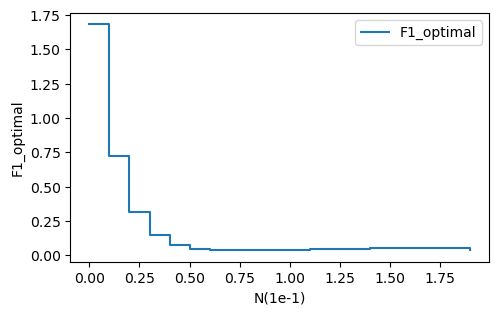

In [19]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Nonlinear system dynamics
def ode(x, t, u):
    H, C = x
    
    dHdt = 1 / 0.5 * (u[0] + u[1] - 0.125 * np.sqrt(H))
    dCdt = 1 / (0.5 * H) * (u[0] * (0.2 - C) + u[1] * (0.5 - C))
    
    return [dHdt, dCdt]

# MPC cost function
def mpc_cost(U, x0, Q, R, N):
    J = 0.0
    x_k = x0
    
    for k in range(N):
        u_k = U[2*k:2*(k+1)]
        x_k1 = odeint(ode, x_k, [0, 0.1], args=(u_k,))
        x_k = x_k1[-1]
        
        J += 0.5 * np.dot((x_k - np.array([1.55, 0.6])).T, np.dot(Q, (x_k - np.array([1., 0.4]))))
        J += 0.5 * np.dot(u_k.T, np.dot(R, u_k))
    
    return J

# MPC optimization
def mpc_optimization(Q, R, x0, N, umin, umax):
    u_init = np.array([1.2, 0.3] * N)  # Initial guess for input trajectory
    u_bounds = [(umin, umax)] * N * 2  # Bounds on the input trajectory

    # Call scipy.optimize.minimize to solve the MPC optimization problem
    sol = minimize(mpc_cost, u_init, args=(x0, Q, R, N), method='SLSQP', bounds=u_bounds, options={'eps': 1e-6, 'disp': True})

    # The optimized input trajectory is stored in sol.x
    U = sol.x.reshape((N, 2))
    
    return U

# Simulation parameters
N = 20  # Number of time steps
T = 0.1  # Time step
Q = np.array([[10, 0], [0, 1]])  # State cost matrix
R = np.array([[1, 0], [0, 1]])  # Input cost matrix
x0 = np.array([0.1, 0.1])  # Initial state
umin, umax = 0, 2  # Input constraints

# Perform MPC
U_optimal = mpc_optimization(Q, R, x0, N, umin, umax)

# Simulate the system with the optimal input
time = np.arange(0, N * T, T)
X_optimal = odeint(ode, x0, time, args=(U_optimal[0],))

# Plot the results in four separate graphs
plt.figure(figsize=(5, 12))

# Plot H_optimal
#plt.subplot(4, 1, 1)
#plt.plot(time, X_optimal[:, 0], label='H_optimal')
#plt.xlabel('Time')
#plt.ylabel('H_optimal')
#plt.legend()

# Plot C_optimal
#plt.subplot(4, 1, 2)
#plt.plot(time, X_optimal[:, 1], label='C_optimal')
#plt.xlabel('Time')
#plt.ylabel('C_optimal')
#plt.legend()

# Plot F1_optimal
plt.subplot(4, 1, 3)
plt.step(time, U_optimal[:, 0], label='F1_optimal', where='post')
plt.xlabel('N(1e-1)')
plt.ylabel('F1_optimal')
plt.legend()

# Plot F2_optimal
#plt.subplot(4, 1, 4)
#plt.step(time, U_optimal[:, 1], label='F2_optimal', where='post')
#plt.xlabel('N(1e-1)')
#plt.ylabel('F2_optimal')
#plt.legend()

plt.tight_layout()
plt.show()
